# Image Classification - Hristo Hristov

## Introduction
My personal challenge will be to make an A.I. model that can do landscapes calssifcation. The 6 landscapes include: buildings, forests, glaciers, mountains, seas and streets. I will be doing this project according to the IBM A.I. Project Methodology.


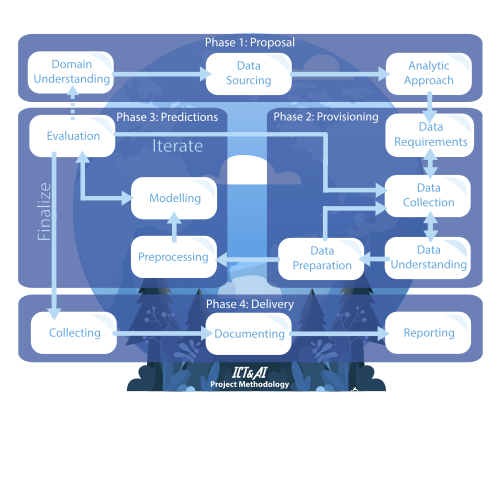

# Phase 1 - Proposal

## 1.1 Domain understanding
The purpose of this project is to make an A.I. that can analyze picture and determine what kind of landscape it is. My data will have 6 different landscapes: building, forest, glacier, mountain, sea and street. My project will help people organize their images into these 6 different categories. The people who will benefit most from this are nature photographers. To achieve my goals I will explore 2 different models: SVM and Keras.

## 1.2 Data sourcing
I will be sourcing my data from a already made dataset from the website keggle. The dataset can be found here: 
https://www.kaggle.com/datasets/puneet6060/intel-image-classification

## 1.3 Analytic approach
### Before we start diving into the data we must first ask ourselves some main research questions, which we will have to answer here in this notebook. 
1. Is our data clean? How do we make sure it is ?
2. Is the class distribution in our data optimal?
2. Which model fits our data best for accurate predictions?

# Phase 2 - Provisioning

## 2.1 Data requirements
Since we will be working with images we do not have a lot of data requirements, however they are all as equaly as important to make sure that our model can use the data. Our requirments are:
- Images must be in a png or jpg format
- Images must not be corrupted - meaning that the file can be opened without giving an error and that the file is in a correct image format (JPG/PNG)
- Images must containt one of the 6 target classes that we have chosen
- Images must be properly sorted in a correctly named folder that coresponds to the images that it contains. (E.g., folder named building must contain buildings)
- Images must be in 150x150  because it gives us the best increase in processing speed without losing too much detail of the picture that will affect accuracy

## Importing needed libraries

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf 
from tensorflow.keras import Sequential
from tqdm import tqdm
from PIL import Image

## 2.2 Data collection + 2.4 Data preparation
### We are going to make a method that will load our data from our train and test folders into 4 different variables. While we are looping through the images in the folders we will also do a little bit of pre-prossessing, such as : checking if the selected file is an actual valid image, changing the color of the image into RGB and resizing the images. 


### Here we will also answer our question 1: Since the dataset of images that we have is already clean. We will make a check using a .verify() method that will see if the image is first of all an actual image and not a different type of file and second of all to make sure that it is not corruputed.

In [2]:
#These are the 6 types of terrains that our daat is caterorized as
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

# Make our image a standerdize size of 150x150
IMAGE_SIZE = (150, 150)

In [3]:
heights = []
widths = []

def load_data():
    #Get our dataset paths
    datasets = ['data/seg_train/seg_train', 'data/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
       
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            #The label is equial to the folder from where we get our image
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                try:
                    img = Image.open(img_path) # open the image file
                    img.verify() # verify that it is, in fact an image and it is not corrupted
                    
                    # Open our image
                    image = cv2.imread(img_path)
                    #Change the color of the image into RGB (some images may not be in RGB)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #Resize all of our images into a small 150x150 size so that we have a quicker processing
                    image = cv2.resize(image, IMAGE_SIZE) 
                    
                    height, width, channels = image.shape
                
                    # Append the image and its corresponding label to the output
                    images.append(image)
                    labels.append(label)
                    heights.append(height)
                    widths.append(width)

                    
                except (IOError, SyntaxError) as e:
                    print('Bad file:', img_path) # print out the names of corrupt files
                
                
        #Convert our images into numpy array so that we can use them for our model.        
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

### Here we can see that our method detects the invalid files that are in the datasets.

In [4]:
#Load our data
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading data/seg_train/seg_train


100%|█████████████████████████████████████████████████████████████████████████████| 2192/2192 [00:03<00:00, 652.42it/s]


Bad file: data/seg_train/seg_train\buildings\decoy.txt


100%|█████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:03<00:00, 752.65it/s]


Loading data/seg_test/seg_test


100%|███████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 703.97it/s]


In [5]:
sum(heights)

2555100

#Plot the result of our train and test counting
plt.pie(heights)
plt.axis('equal')
plt.title('Proportion of classes in the TRAIN data')
plt.show()

## 2.3 Data Understanding
### Let's start understanind our data by plotting the class distribution in our train and test and answering the 2nd question. 2A: We can see that there is already a pretty good and even distribution between the classes in our train and test data, meaning that we will not need to reshuffle our data.

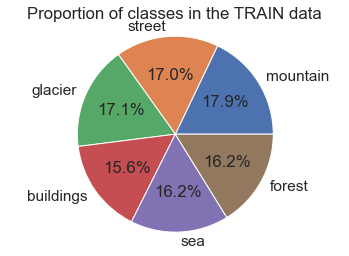

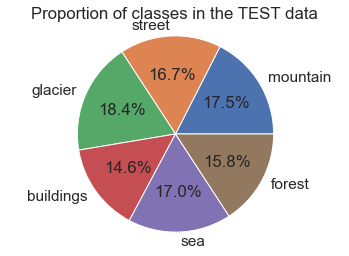

In [6]:
import pandas as pd

#Count the labels we have 
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)

#Plot the result of our train and test counting
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of classes in the TRAIN data')
plt.show()


plt.pie(test_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of classes in the TEST data')
plt.show()

### A: When we compare our train dataset to our test dataset we can see that the data is evenly distributed between all of our classes, thus there is no need for us to reshuffle our data.

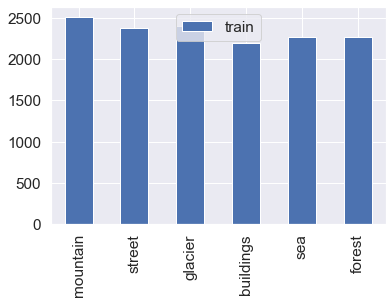

In [7]:
pd.DataFrame({'train': train_counts,
                    }, 
             index=class_names
            ).plot.bar()
plt.show()

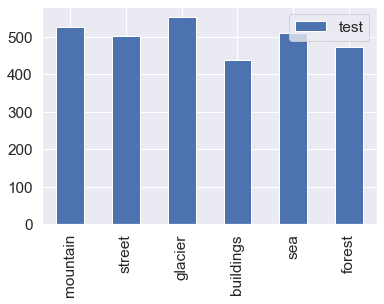

In [8]:
pd.DataFrame({'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

### Let's actually see some examples of our images by printing out 25 random images from out train dataset with the corresponding label

In [9]:
def display_examples(class_names, images, labels):
 
 # Display 25 random images from the dataset
  
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    
    for i in range(25):
        #Take a random index from our image array
        index = np.random.randint(images.shape[0])
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        #Show the image using the randomly made index
        plt.imshow(images[index].astype('uint8'), cmap=plt.cm.binary)
        #Take the label using the same random index
        plt.xlabel(class_names[labels[index]])
    plt.show()

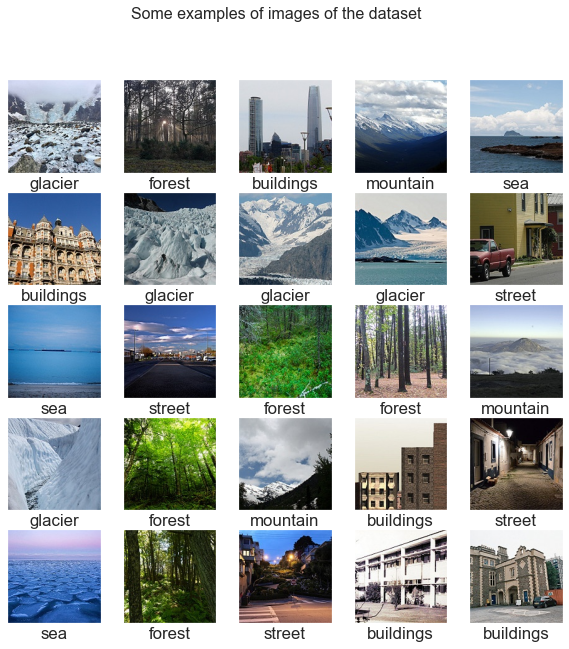

In [10]:
display_examples(class_names, train_images, train_labels)

## 2.4 Data preparation 
### We are going to scale our images again due to the reason that we have over 4000 images and we will need our model to process them in a reasonable amount of time. Also in our particular case (landscape classification) we are not interested in any particular object in the images, we are not doing any object detection.

In [11]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

# Conclusion

# Phase 3 - Prediction

# 3.2 Modeling

I will be using first the keras layers model. Here is the description for what each layer does:

keras.layers.Conv2D is a 2D Convolution Layer and this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs. In the param we use filters = 10 which is mean is the number of filters that the convolutional layer will learn. kernel_size = 3,  it's a 2-tuple specifying the width and height of the 2D convolution window and kernel_size must be an odd integer as well. Activation = relu, relu is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero.

Keras.layers.MaxPool2D is a Max pooling operation for 2D spatial data. Downsamples the input along its spatial dimensions like height and width by taking the maximum value over an input of size defined by pool_size for each channel of the input. In the param we use pool_size = 2, it's an integer or tuple of 2 integers, window size over which to take the maximum. We only specified 1 integer which is mean we're going to use the same window length. For padding we use = valid which means means no padding.

keras.layers.Flatten is use to flattens the multi-dimensional input tensors into a single dimension.

keras.layers.Dense, we're going to use it on the output layer to performs dot product of input tensor and weight kernel matrix. In the param we use units = units = len(classes), classes is th list of the unique label (or images) in the train_df. Activation = softmax is used as the activation for the last layer of a classification network because the result could be interpreted as a probability distribution.

In [12]:
#Make our model
KerasModel = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [13]:
#Compile our model
KerasModel.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

### We are going to use 2 callback methods when fitting our data. One that will stop running our epoch after it detects that we are overfitting our data and the second to tell us how much time it takes for each epoch to run.


In [14]:
import time

from keras import callbacks
#This method will stop running our ephos after it has determined that the accuracy no-longer increases as need
earlystopping = callbacks.EarlyStopping(monitor = 'accuracy',mode = 'min',patience = 5,restore_best_weights=True,verbose=1)

#This method will track the time and in the end tell us how long it took for the epoch to run
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = time.perf_counter()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((epoch,time.perf_counter() - self.timetaken))
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(*zip(*self.times))
        plt.show()

### Our model was struggling to achive high accuracy due to a couple of reasons: 
- Incorrect ephocs defined, making the data overfitted
- Layer tweaks were needed

Sources: https://datascience.stackexchange.com/questions/57171/how-to-improve-low-accuracy-keras-model-design
- DOT Framework : Library
- Method : Literature Study

### For further improvments we will need to do some hyperparamter tuning
- https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53
- DOT Framework : Library
- Method : Literature Study

Epoch 1/5
878/878 [==============================] - 173s 196ms/step - loss: 0.8959 - accuracy: 0.6590
Epoch 2/5
878/878 [==============================] - 174s 198ms/step - loss: 0.5436 - accuracy: 0.8022
Epoch 3/5
878/878 [==============================] - 174s 198ms/step - loss: 0.3061 - accuracy: 0.8924
Epoch 4/5
878/878 [==============================] - 164s 187ms/step - loss: 0.1510 - accuracy: 0.9501
Epoch 5/5
878/878 [==============================] - 158s 179ms/step - loss: 0.0836 - accuracy: 0.9733


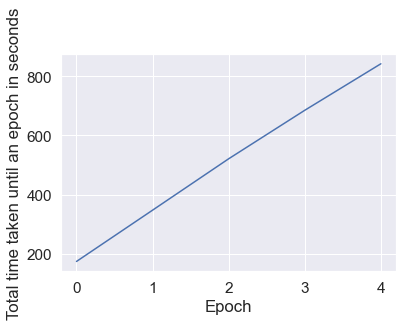

In [15]:
timeittakes = timecallback()
prediction = KerasModel.fit(train_images, train_labels, batch_size=16, epochs=5, callbacks = [timeittakes,earlystopping])

## 3.3 Evaluation

### Let's evalate our results that we have after running our model. We can see that after each ephoc the acurracy is increasing and the loss is decreasing

In [16]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.title("train_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    #Plot our loss
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.title("train_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

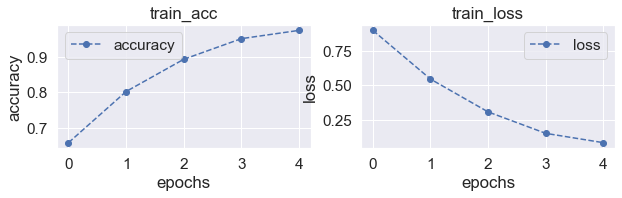

In [17]:
plot_accuracy_loss(prediction)

### When we evaluate our model on our test images we can see that we still have around 80 accuracy

In [18]:
evaluation = KerasModel.evaluate(test_images, test_labels)

94/94 [==============================] - 9s 92ms/step - loss: 0.9355 - accuracy: 0.7467


### Lets display a random image and the it's predicted label

In [24]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    #Take a random index
    index = np.random.randint(images.shape[0])
    plt.figure()
    #Show random image from the variable 'images' provided
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

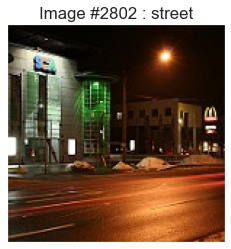

In [25]:
predictions = KerasModel.predict(test_images)     # Predict the test images
pred_labels = np.argmax(predictions, axis = 1) # Take the prediction labels from the actual prediction

#Display a random image from the predicted test images
display_random_image(class_names, test_images, pred_labels)

## Predicting photos from personal galery

In [26]:
def getClass(predLabel):
    i = 0
    for x in predclass:
        for xb in x:
            if xb == 1:
                return class_names[i]
            i += 1

In [27]:
def render_image(image):
    plt.rcParams["axes.grid"] = False
    plt.figure(figsize = (12, 8))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(image).astype('uint8'))
    plt.xlabel(getClass(predclass))
    plt.show

In [29]:
from keras.preprocessing import image
img_width , img_height = 150 ,150
img = image.load_img('as.jpg', target_size = (img_width, img_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

predclass = KerasModel.predict(img)

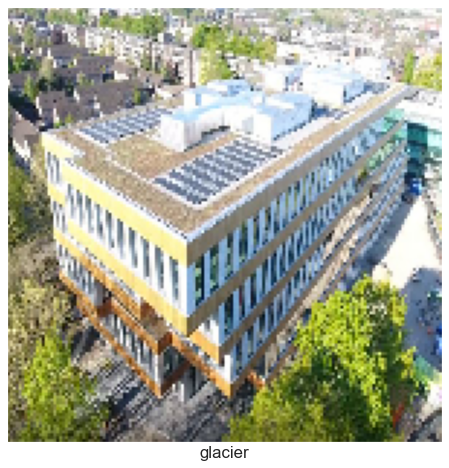

In [30]:
render_image(img)

In [31]:
img = image.load_img('Vacation.jpg', target_size = (img_width, img_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

predclass = KerasModel.predict(img)

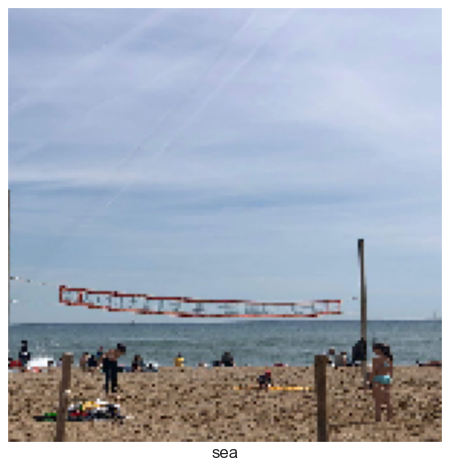

In [32]:
render_image(img)

### Let's print out 25 random images that have been mislabeled by our model

In [33]:
def display_badexamples(class_names, images, labels, pred):
 
 # Display 25 random images from the dataset
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of mislabeled images by the classifier:", fontsize=16)
    
    for i in range(25):
        #Take random index
        index = np.random.randint(images.shape[0])
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[index], cmap=plt.cm.binary)
        plt.xlabel(class_names[pred[index]])
    plt.show()

In [34]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
        #Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
        
    #This will give us a result of either 1 or 0. 1 being a correct label, 0 being an incorrect label    
    BOO = (test_labels == pred_labels)
    #Take all indexes that are 0 (wrongly predicted)
    mislabeled_indices = np.where(BOO == 0)
    #Take mislabeled images
    mislabeled_images = test_images[mislabeled_indices]
    #Take the incorrect predicted label
    mislabeled_labels = pred_labels[mislabeled_indices]

    #Display them
    display_badexamples(class_names, mislabeled_images, test_labels, mislabeled_labels)

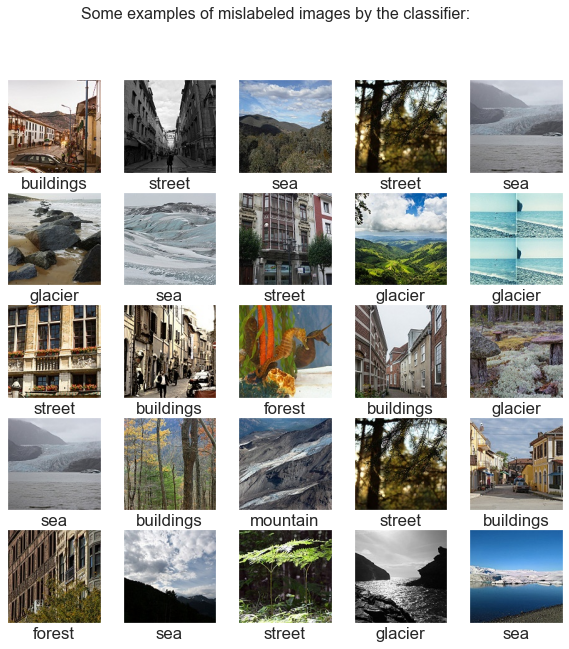

In [35]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

### By using confusion matrix we can see what our model is struggeling with. Street - buildings, glacier - mountain and sea - mountain are the pairs that our model has trouble differentiating between 

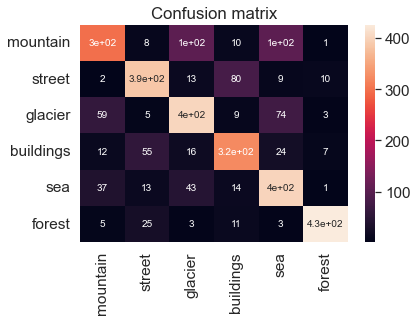

In [36]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

## 2.2 Data collecton - Looping back
### Now that we have tried our keras model, let's try to see how a SVM model will perform. First we will load the data

In [37]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

flat_data_arr=[] #input array
target_arr=[] #output array
datadir='data/seg_SVMtrain/seg_SVMtrain' 

#path which contains all the categories of images
for i in os.listdir(datadir):
    
    print(f'loading... category : {i}')
    for img in tqdm(os.listdir(os.path.join(datadir, i))):
        try:
            #Join the path for our image 
            img_path = os.path.join(os.path.join(datadir, i), img)    
             # open the image file
            img = Image.open(img_path)
            # verify that it is, in fact an image
            img.verify() 
            #Add the image to the array
            img_array=imread(img_path)
            #Resize all of our images from the array into 150x150 size 
            img_resized=resize(img_array,(150,150,3))
            flat_data_arr.append(img_resized.flatten())
            #Add our resized array
            target_arr.append(os.listdir(datadir).index(i))
                    
        except (IOError, SyntaxError) as e:
            print('Bad file:', img_path) # print out the names of corrupt files
    print(f'loaded category:{i} successfully')        
            
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
#Convert our data into a dataframe
df=pd.DataFrame(flat_data) 
#Add our target column to the dataframe
df['Target']=target
   
x=df.iloc[:,:-1] #x data 
y=df.iloc[:,-1] #y data

loading... category : buildings


100%|███████████████████████████████████████████████████████████████████████████████| 456/456 [00:03<00:00, 126.82it/s]


Bad file: data/seg_SVMtrain/seg_SVMtrain\buildings\decoy.txt
loaded category:buildings successfully
loading... category : forest


100%|███████████████████████████████████████████████████████████████████████████████| 527/527 [00:04<00:00, 124.52it/s]


loaded category:forest successfully
loading... category : glacier


100%|███████████████████████████████████████████████████████████████████████████████| 444/444 [00:03<00:00, 125.69it/s]


loaded category:glacier successfully
loading... category : mountain


100%|███████████████████████████████████████████████████████████████████████████████| 536/536 [00:04<00:00, 124.71it/s]


loaded category:mountain successfully
loading... category : sea


100%|███████████████████████████████████████████████████████████████████████████████| 402/402 [00:03<00:00, 127.78it/s]


loaded category:sea successfully
loading... category : street


100%|███████████████████████████████████████████████████████████████████████████████| 422/422 [00:03<00:00, 116.75it/s]


loaded category:street successfully


In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#Split our data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42)
print('Splitted Successfully')


Splitted Successfully


# 2.3 Data understanding

### Here we can see our train images for our SVM model. They have been converted to fit into a dataframe. Each number for a row is a pixel that the computer can convert and read.

In [39]:
x_train

,0,1,2,3,4,5,6,7,8,9,...,67490,67491,67492,67493,67494,67495,67496,67497,67498,67499
599,0.501961,0.517647,0.552941,0.376471,0.396078,0.419608,0.564706,0.576471,0.596078,0.658824,...,4.980392e-01,0.572549,0.380392,0.360784,0.317647,0.172549,0.141176,3.921569e-01,2.862745e-01,2.588235e-01
1518,0.905882,0.941176,0.960784,0.901961,0.937255,0.956863,0.901961,0.937255,0.956863,0.901961,...,2.666667e-01,0.345098,0.392157,0.298039,0.313725,0.360784,0.282353,3.058824e-01,3.568627e-01,2.862745e-01
2746,0.807843,0.847059,0.854902,0.592157,0.631373,0.627451,0.537255,0.580392,0.549020,0.219608,...,3.176471e-01,0.294118,0.298039,0.313725,0.294118,0.298039,0.313725,2.901961e-01,2.941176e-01,3.098039e-01
100,0.164706,0.533333,0.745098,0.149020,0.545098,0.764706,0.152941,0.549020,0.752941,0.200000,...,4.705882e-02,0.090196,0.129412,0.035294,0.090196,0.129412,0.031373,8.627451e-02,1.372549e-01,3.529412e-02
315,0.219608,0.172549,0.219608,0.200000,0.160784,0.203922,0.180392,0.141176,0.184314,0.313725,...,3.568627e-01,0.572549,0.427451,0.356863,0.572549,0.427451,0.364706,5.686275e-01,4.235294e-01,3.607843e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0.239216,0.533333,0.788235,0.172549,0.466667,0.721569,0.109804,0.415686,0.674510,0.098039,...,2.666667e-01,0.223529,0.235294,0.294118,0.321569,0.329412,0.388235,3.215686e-01,3.294118e-01,3.882353e-01
1095,0.756863,0.803922,0.858824,0.760784,0.796078,0.862745,0.752941,0.784314,0.858824,0.737255,...,8.980392e-01,0.843137,0.882353,0.980392,0.572549,0.611765,0.717647,3.529412e-01,3.882353e-01,5.019608e-01
1130,0.482353,0.498039,0.509804,0.482353,0.498039,0.509804,0.486275,0.501961,0.513725,0.490196,...,6.745098e-01,0.741176,0.733333,0.686275,0.717647,0.709804,0.662745,7.529412e-01,7.450980e-01,6.980392e-01
1294,0.239216,0.380392,0.521569,0.207843,0.356863,0.501961,0.215686,0.368627,0.521569,0.172549,...,6.666667e-01,0.611765,0.658824,0.643137,0.600000,0.647059,0.631373,6.235294e-01,6.705882e-01,6.549020e-01


### These are the labels for our image files. They go from 0 to 5, coresponding to our 6 different landscapes

In [40]:
y_train

599     1
1518    3
2746    5
100     0
315     0
       ..
1638    3
1095    2
1130    2
1294    2
860     1
Name: Target, Length: 2228, dtype: int32

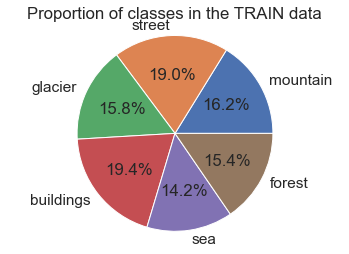

In [41]:
#Count the labels we have 
_, train_counts = np.unique(y_train, return_counts=True)
#Plot the result of our train and test counting
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of classes in the TRAIN data')
plt.show()


# 3.2 Modeling

### Import our SVM model and set some parameters to see how it would perform

In [42]:
from sklearn.svm import SVC # SVC is for classification, an SVR for regression exists as well.
SVMModel = SVC(gamma = 'scale')
SVMModel.fit(x_train,y_train)

SVC()

In [43]:
y_pred=SVMModel.predict(x_test)


### We can see that our model has an average accuracy which is not good. 

In [44]:
from sklearn.metrics import accuracy_score
print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")

The model is 62.00716845878136% accurate


# 3.4 Evaluation

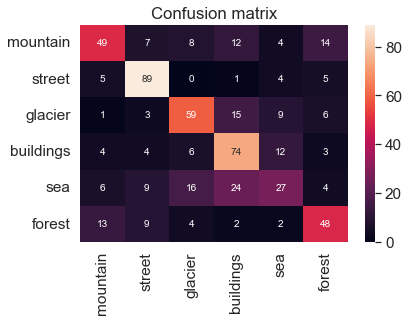

In [45]:
CM = confusion_matrix(y_test, y_pred)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

### Let's try to improve our accuracy by tuning our hyperparameters using Grid Search

In [46]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

param_grid={'C':[0.1,1],'gamma':['scale','auto'],'kernel':['rbf','poly']}
svc=svm.SVC(probability=False)
SVMModel=GridSearchCV(svc,param_grid)

In [47]:
SVMModel.fit(x_train,y_train)
print('The Model is trained well with the given images')
#model.best_params_ contains the best parameters obtained from GridSearchCV

The Model is trained well with the given images


In [48]:
SVMModel.best_params_

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [49]:
y_pred=SVMModel.predict(x_test)

### Even after tuning our hyperparameters we still get quite a low accuracy. This tells us that SVM is not a good model to use in this particular case

In [50]:
from sklearn.metrics import accuracy_score
print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")

The model is 62.00716845878136% accurate
